In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from itertools import product
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from catboost import CatBoostRegressor, Pool

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Ensure TensorFlow operates deterministically
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

dow_jones_df = pd.read_csv("dow_jones_data_clean.csv")

# Display the first few rows and column names of the dataset
dow_jones_df.head(), dow_jones_df.columns

(                        Date  Adj Close     Close      High       Low  \
 0  1980-12-12 00:00:00+00:00   0.098943  0.128348  0.128906  0.128348   
 1  1980-12-15 00:00:00+00:00   0.093781  0.121652  0.122210  0.121652   
 2  1980-12-16 00:00:00+00:00   0.086898  0.112723  0.113281  0.112723   
 3  1980-12-17 00:00:00+00:00   0.089049  0.115513  0.116071  0.115513   
 4  1980-12-18 00:00:00+00:00   0.091630  0.118862  0.119420  0.118862   
 
        Open     Volume Ticker  
 0  0.128348  469033600   AAPL  
 1  0.122210  175884800   AAPL  
 2  0.113281  105728000   AAPL  
 3  0.115513   86441600   AAPL  
 4  0.118862   73449600   AAPL  ,
 Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
        'Ticker'],
       dtype='object'))

In [2]:
dow_jones_df.info()
dow_jones_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361538 entries, 0 to 361537
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       361538 non-null  object 
 1   Adj Close  361538 non-null  float64
 2   Close      361538 non-null  float64
 3   High       361538 non-null  float64
 4   Low        361538 non-null  float64
 5   Open       361538 non-null  float64
 6   Volume     361538 non-null  int64  
 7   Ticker     361538 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 22.1+ MB


,Date,Adj Close,Close,High,Low,Open,Volume,Ticker
count,361538,361538.000000,361538.000000,361538.000000,361538.000000,361538.000000,3.615380e+05,361538
unique,15821,NaN,NaN,NaN,NaN,NaN,NaN,28
top,2012-04-20 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,KO
freq,28,NaN,NaN,NaN,NaN,NaN,NaN,15821
mean,NaN,34.735950,44.823122,45.261430,44.365490,44.636039,2.053661e+07,NaN
std,NaN,59.699655,64.121151,64.724787,63.490108,64.223467,8.102556e+07,NaN
min,NaN,0.002845,0.005208,0.005208,0.004801,0.000000,0.000000e+00,NaN
25%,NaN,1.324075,4.270833,4.312500,4.226386,3.733622,2.124347e+06,NaN
50%,NaN,11.948401,21.945000,22.187500,21.690001,21.920000,5.294992e+06,NaN
75%,NaN,40.156898,55.970001,56.500000,55.408287,55.972920,1.253280e+07,NaN


In [3]:
# Check for missing values
missing_values = dow_jones_df.isnull().sum()
missing_values

Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Ticker       0
dtype: int64

In [4]:
# Convert 'Date' column to datetime format
dow_jones_df['Date'] = pd.to_datetime(dow_jones_df['Date'])

# Set 'Date' as the index
dow_jones_df.set_index('Date', inplace=True)

# Display the updated DataFrame
dow_jones_df.head()

,Adj Close,Close,High,Low,Open,Volume,Ticker
Date,,,,,,,
1980-12-12 00:00:00+00:00,0.098943,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1980-12-15 00:00:00+00:00,0.093781,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
1980-12-16 00:00:00+00:00,0.086898,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
1980-12-17 00:00:00+00:00,0.089049,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
1980-12-18 00:00:00+00:00,0.091630,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


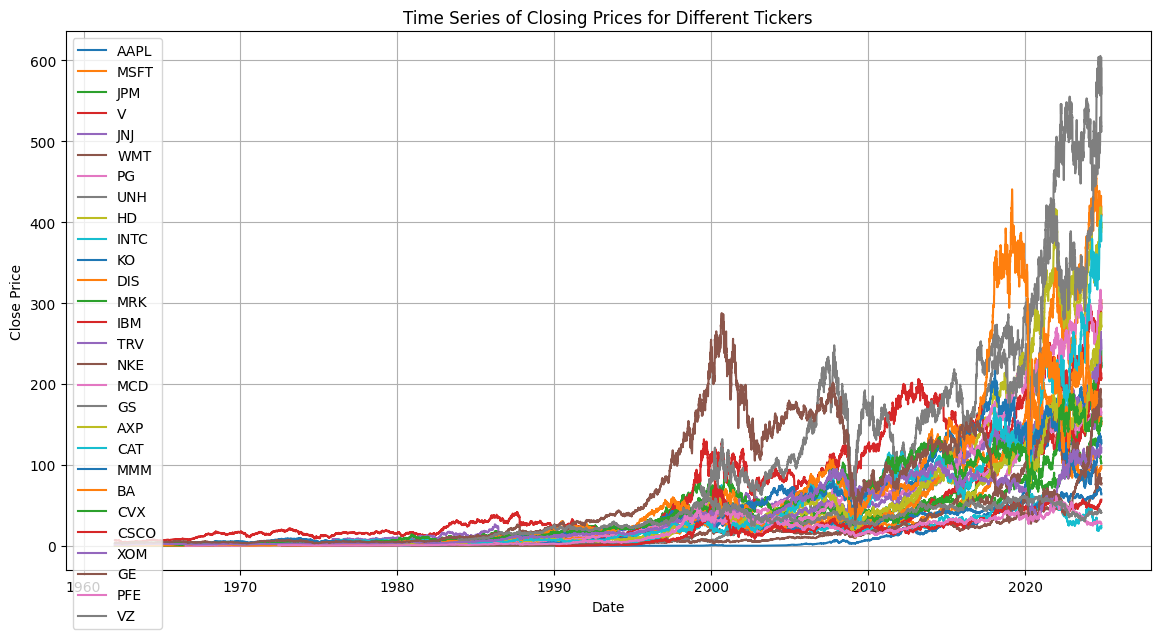

In [5]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['Close'], label=ticker)

plt.title('Time Series of Closing Prices for Different Tickers')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

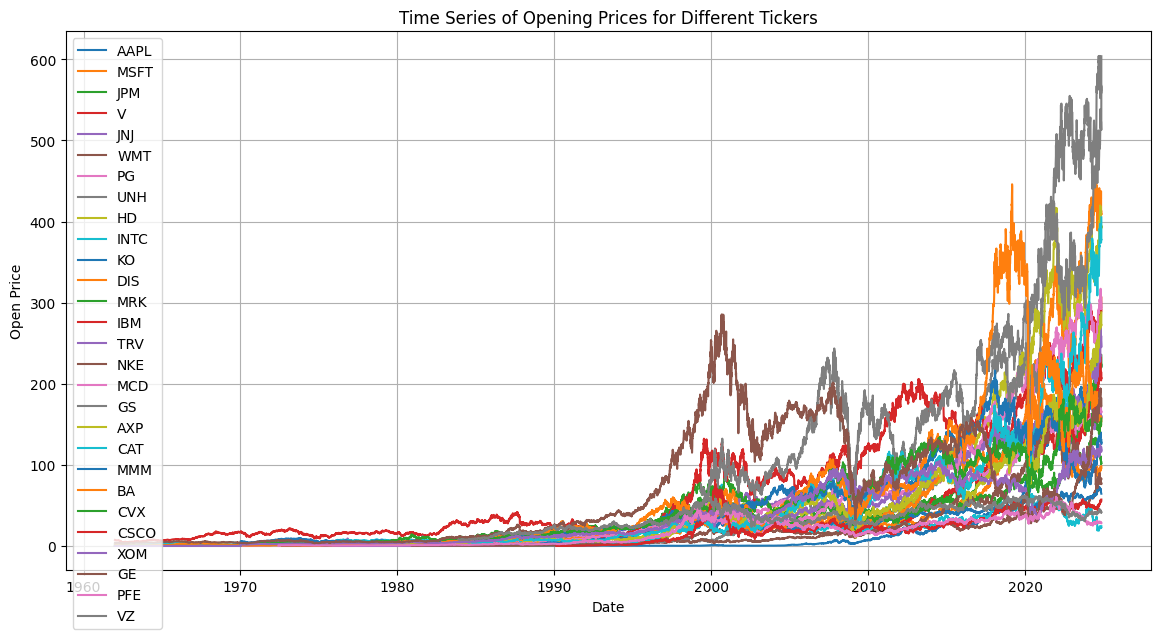

In [6]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['Open'], label=ticker)

plt.title('Time Series of Opening Prices for Different Tickers')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True)
plt.show()

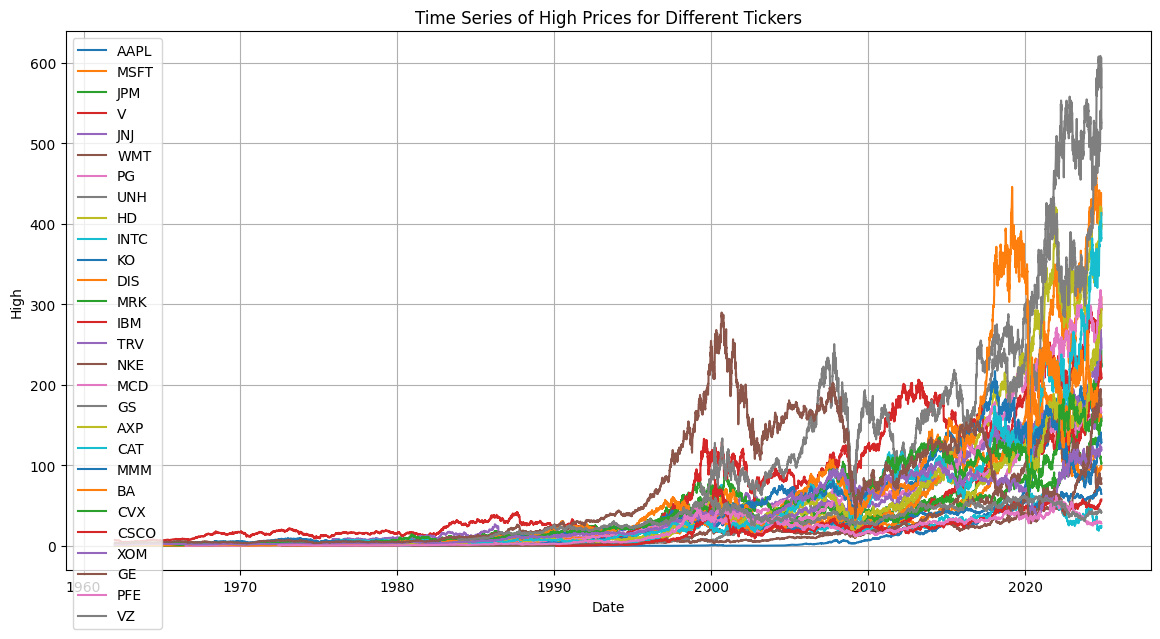

In [7]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['High'], label=ticker)

plt.title('Time Series of High Prices for Different Tickers')
plt.xlabel('Date')
plt.ylabel('High')
plt.legend()
plt.grid(True)
plt.show()

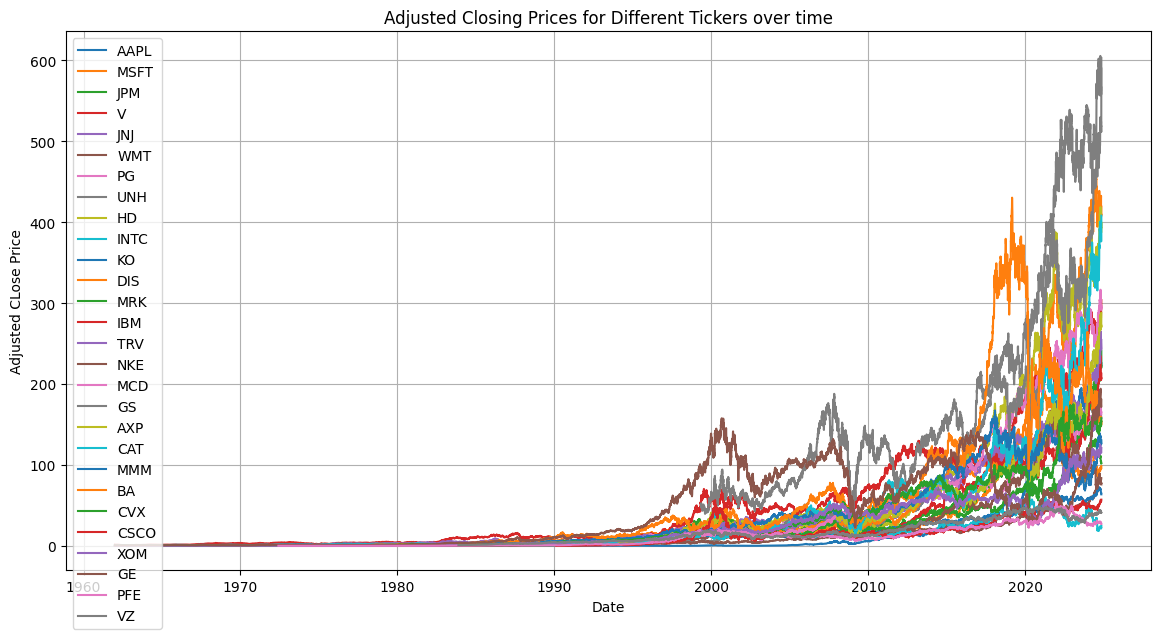

In [8]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label=ticker)

plt.title('Adjusted Closing Prices for Different Tickers over time')
plt.xlabel('Date')
plt.ylabel('Adjusted CLose Price')
plt.legend()
plt.grid(True)
plt.show()

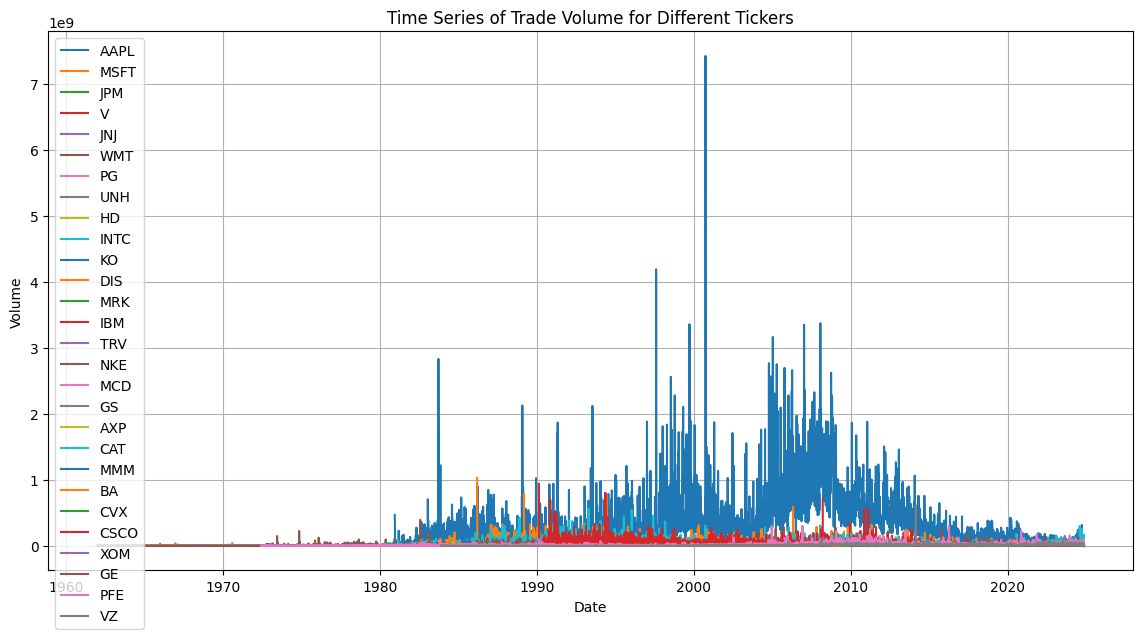

In [9]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['Volume'], label=ticker)

plt.title('Time Series of Trade Volume for Different Tickers')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

## AAPL data graphing

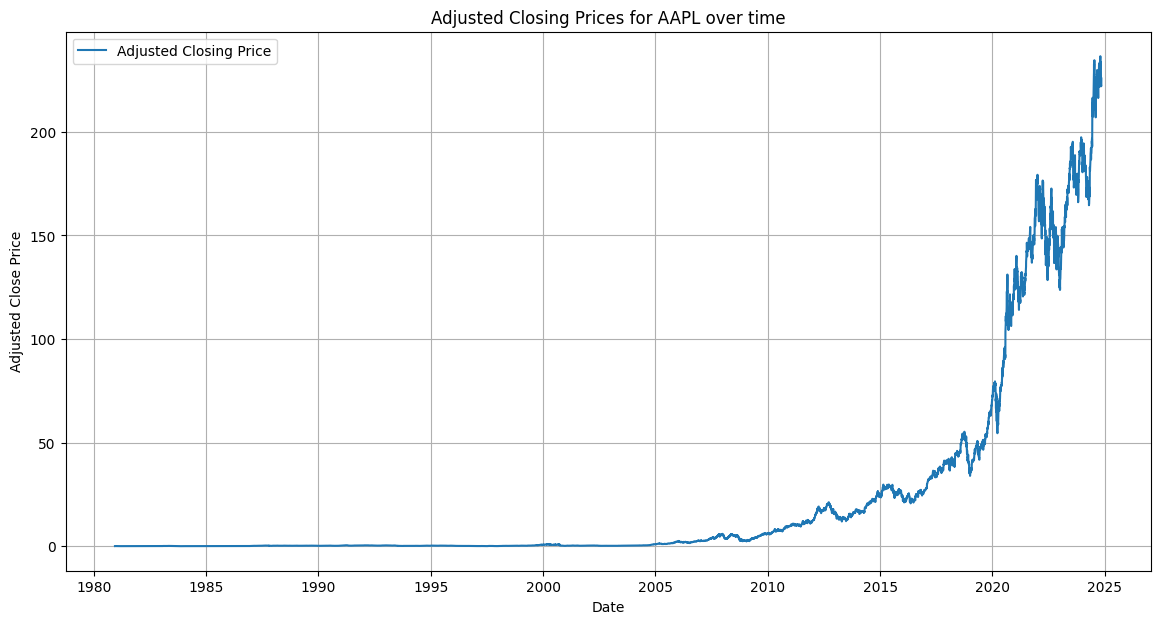

In [10]:
AAPL_data =  dow_jones_df[dow_jones_df['Ticker'] == "AAPL"]
plt.figure(figsize=(14, 7))
plt.plot(AAPL_data.index, AAPL_data['Adj Close'], label= 'Adjusted Closing Price')
plt.title('Adjusted Closing Prices for AAPL over time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

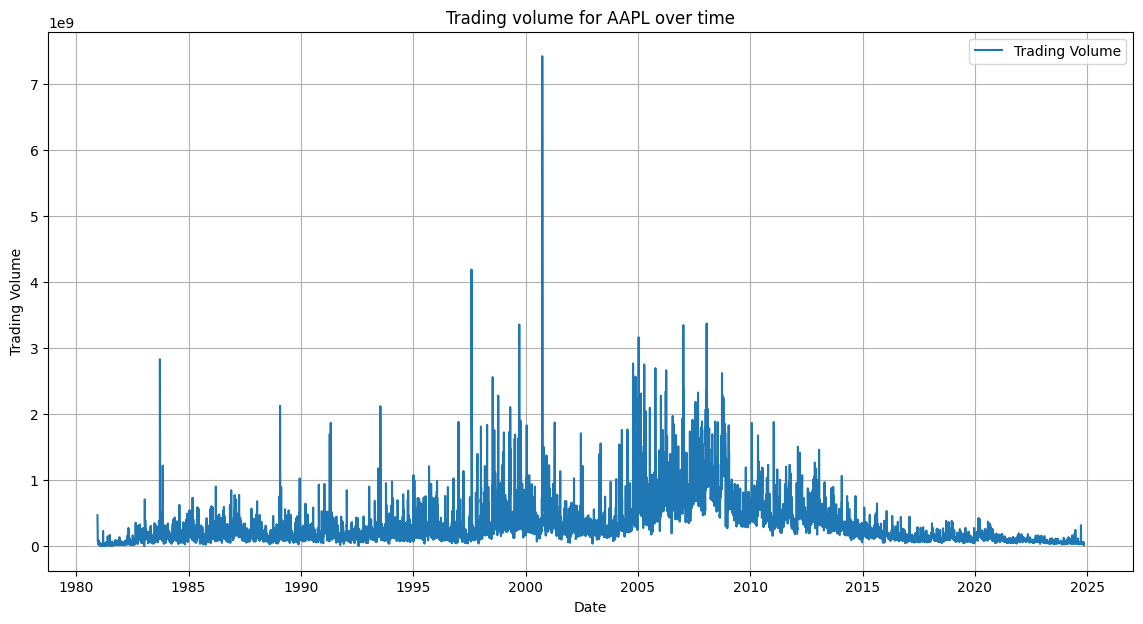

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(AAPL_data.index, AAPL_data['Volume'], label= 'Trading Volume')
plt.title('Trading volume for AAPL over time')
plt.xlabel('Date')
plt.ylabel('Trading Volume')
plt.legend()
plt.grid(True)
plt.show()

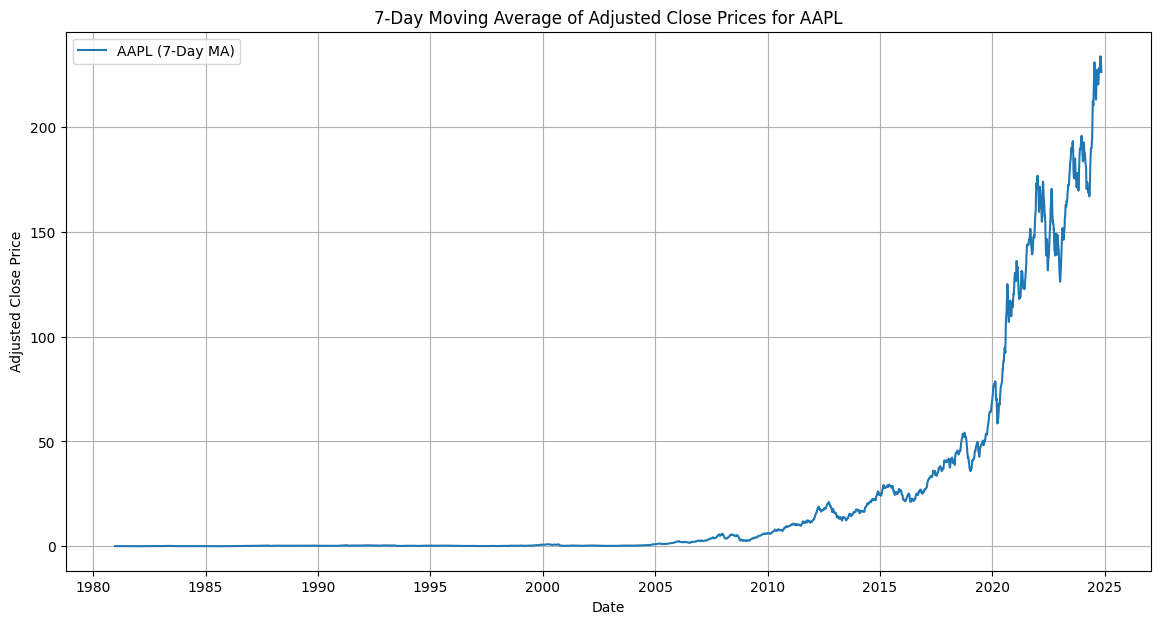

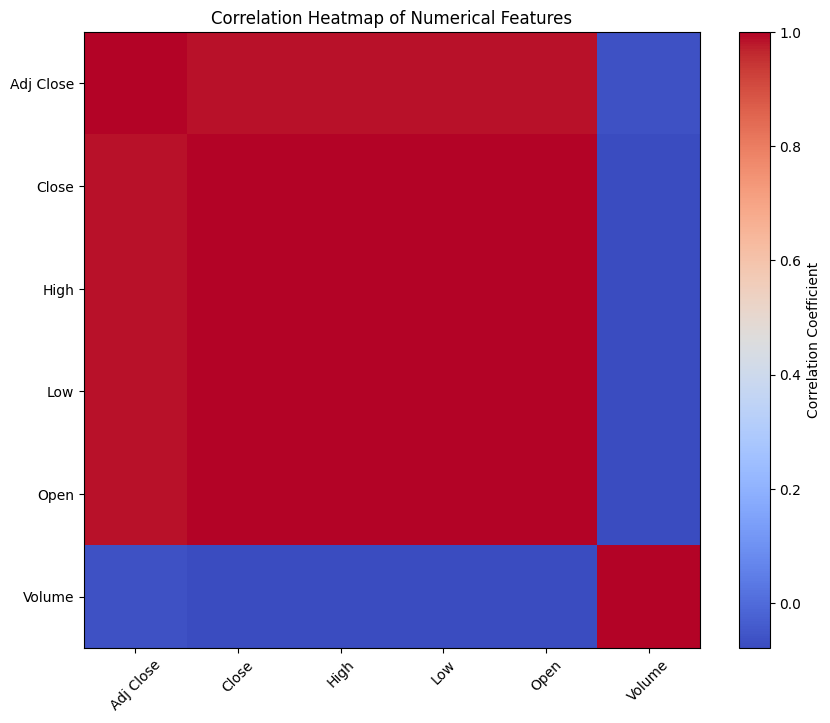

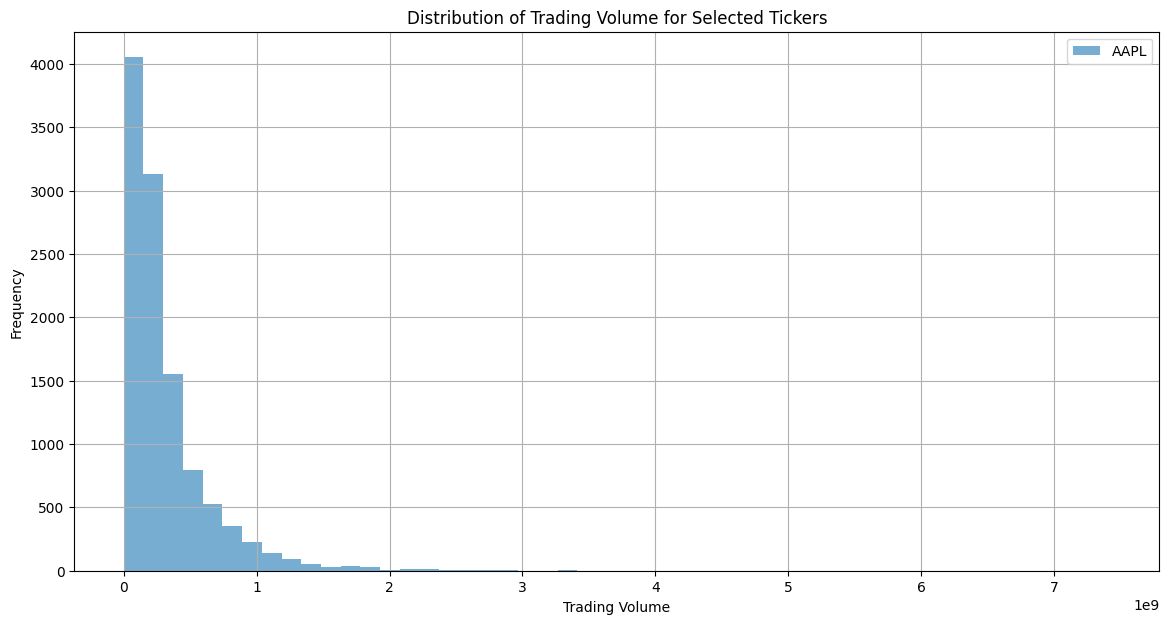

In [12]:
selected_tickers = ['AAPL']
plt.figure(figsize=(14, 7))
for ticker in selected_tickers:
    ticker_data = AAPL_data[AAPL_data['Ticker'] == ticker]
    ticker_data['7-Day MA'] = ticker_data['Adj Close'].rolling(window=7).mean()
    plt.plot(ticker_data.index, ticker_data['7-Day MA'], label=f"{ticker} (7-Day MA)")

plt.title("7-Day Moving Average of Adjusted Close Prices for AAPL")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.grid(True)
plt.show()

# Correlation Heatmap for numerical features
numerical_data = dow_jones_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']]
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
plt.title("Correlation Heatmap of Numerical Features")
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(numerical_data.columns)), numerical_data.columns, rotation=45)
plt.yticks(range(len(numerical_data.columns)), numerical_data.columns)
plt.grid(False)
plt.show()

# Distribution of Trading Volume for the selected tickers
plt.figure(figsize=(14, 7))
for ticker in selected_tickers:
    ticker_data = AAPL_data[AAPL_data['Ticker'] == ticker]
    plt.hist(ticker_data['Volume'], bins=50, alpha=0.6, label=ticker)

plt.title("Distribution of Trading Volume for Selected Tickers")
plt.xlabel("Trading Volume")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

### Exploring seasonal decompose for AAPL data

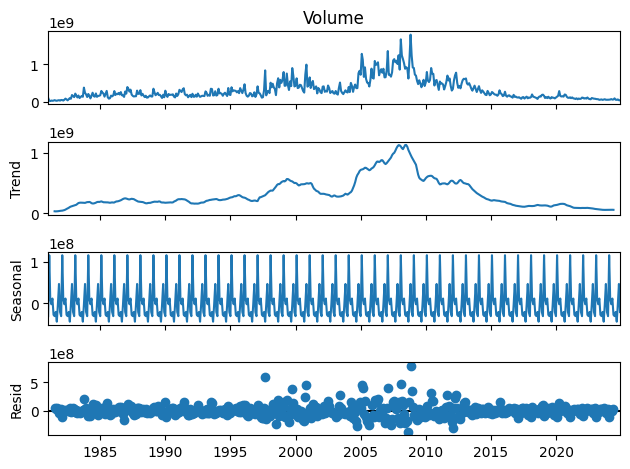

<Figure size 1000x600 with 0 Axes>

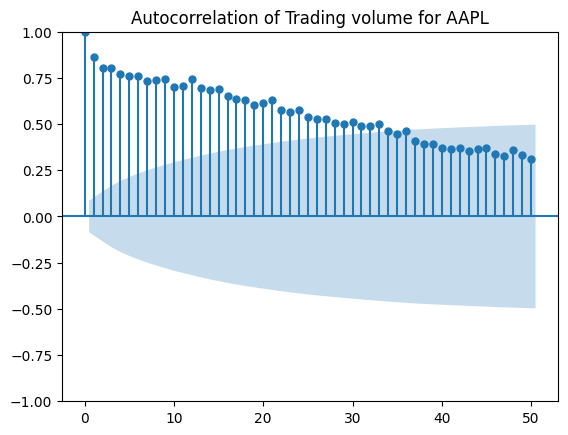

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Decompose the time series (monthly data)
AAPLmonthly_data = AAPL_data['Volume'].resample('M').mean()
decomposition = seasonal_decompose(AAPLmonthly_data, model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

# Plot the ACF to check for seasonality
plt.figure(figsize=(10, 6))
plot_acf(AAPLmonthly_data, lags=50, title='Autocorrelation of Trading volume for AAPL')
plt.show()

##Deep Learning methods

In [14]:
date_time = AAPL_data.index
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [15]:
day = 24*60*60
week = 7 * day
year = (365.25) * day
AAPL_data['log vol'] = np.log1p(AAPL_data['Volume'])
AAPL_data['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
AAPL_data['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
AAPL_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
AAPL_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

C:\Users\Isaya Acevedo\AppData\Local\Temp\ipykernel_1612\3116598882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAPL_data['log vol'] = np.log1p(AAPL_data['Volume'])
C:\Users\Isaya Acevedo\AppData\Local\Temp\ipykernel_1612\3116598882.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAPL_data['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
C:\Users\Isaya Acevedo\AppData\Local\Temp\ipykernel_1612\3116598882.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Text(0.5, 1.0, 'Day of week signal')

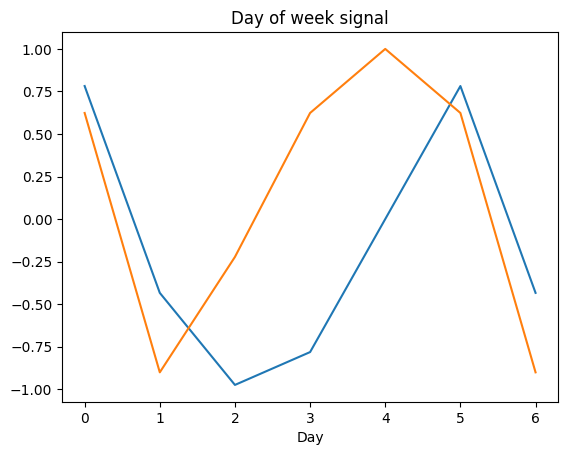

In [16]:
plt.plot(np.array(AAPL_data['Week sin'])[:7])
plt.plot(np.array(AAPL_data['Week cos'])[:7])
plt.xlabel('Day')
plt.title('Day of week signal')

In [17]:
df_aapl = AAPL_data.drop(columns=['Ticker'], axis=1)
column_indices = {name: i for i, name in enumerate(df_aapl.columns)}
n = len(df_aapl)

train_df = df_aapl[0:int(n*0.7)]
val_df = df_aapl[int(n*0.7):int(n*0.9)]
test_df = df_aapl[int(n*0.9):]

num_features = df_aapl.shape[1]


In [18]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

C:\Users\Isaya Acevedo\AppData\Local\Temp\ipykernel_1612\962235012.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_aapl.keys(), rotation=90)


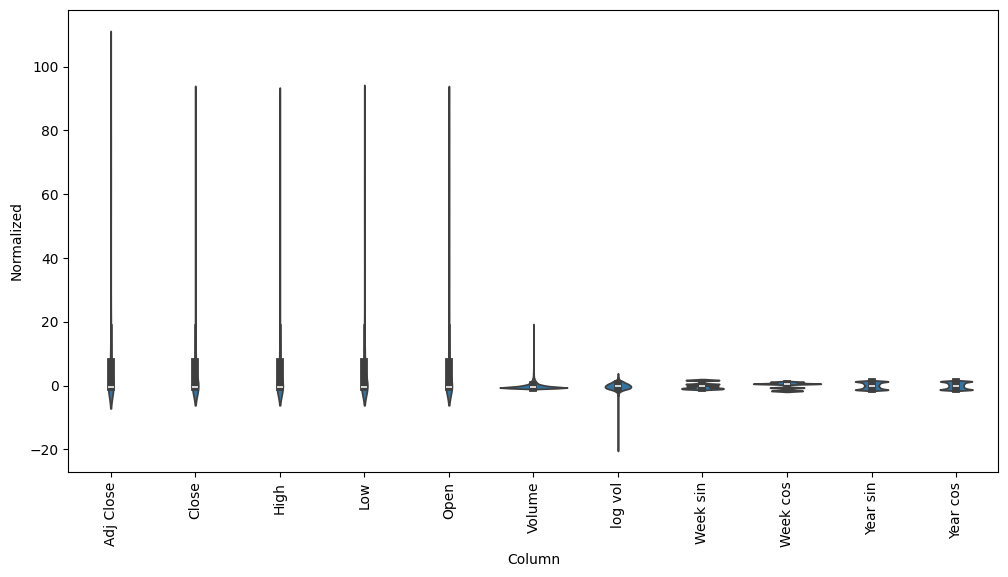

In [19]:
import seaborn as sns
df_std = (df_aapl - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_aapl.keys(), rotation=90)

In [20]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [21]:
import tensorflow as tf
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [22]:
def plot(self, model=None, plot_col='log vol', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

In [23]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [24]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Single-output CNN

In [25]:
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['log vol'])

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [26]:
import IPython
import IPython.display
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [27]:
val_performance = {}
performance = {}
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)


69/69 [==============================] - 0s 632us/step - loss: 0.5452 - mean_absolute_error: 0.5393


In [28]:
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['log vol'])

wide_conv_window

Total window size: 14
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): ['log vol']

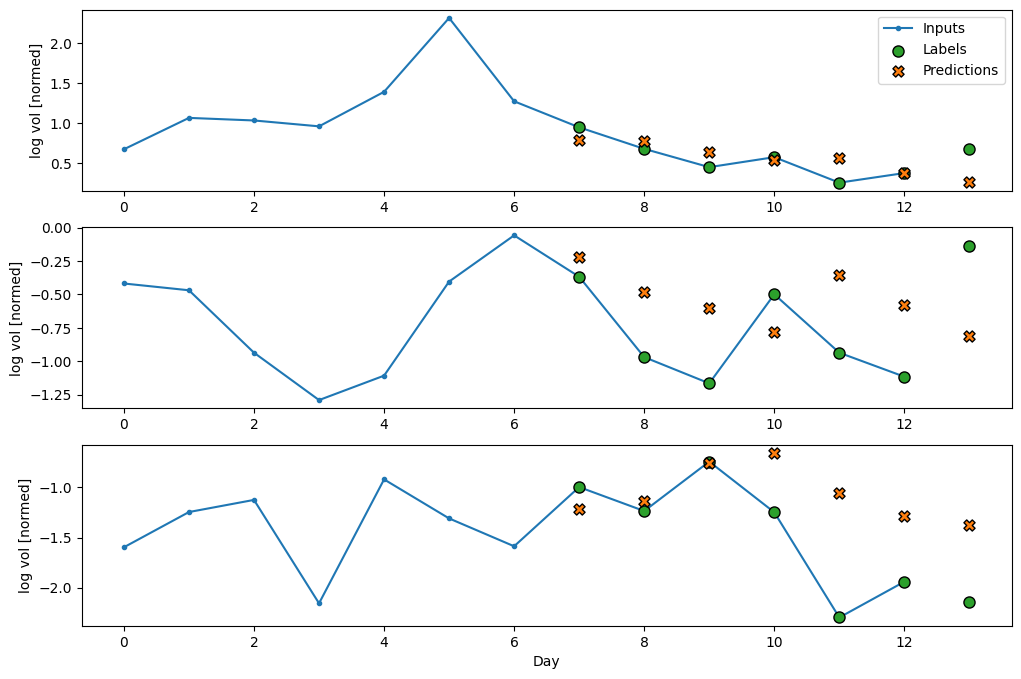

In [29]:
wide_conv_window.plot(conv_model)

In [30]:
metric_name = 'mean_absolute_error'
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Conv        : 4.5389


Multi-output model

In [31]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

In [32]:
history = compile_and_fit(conv_model, wide_window)

IPython.display.clear_output()
val_performance['Multi output Conv'] = conv_model.evaluate(wide_window.val, return_dict=True)
performance['Multi output Conv'] = conv_model.evaluate(wide_window.test, verbose=0, return_dict=True)


69/69 [==============================] - 0s 685us/step - loss: 47.4837 - mean_absolute_error: 6.0714


In [33]:
%%time

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0, return_dict=True)

print()

69/69 [==============================] - 0s 1ms/step - loss: 26.8177 - mean_absolute_error: 2.7550

CPU times: total: 3.47 s
Wall time: 32.5 s


In [34]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [35]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

69/69 [==============================] - 0s 1ms/step - loss: 0.1028 - mean_absolute_error: 0.1847

CPU times: total: 2.5 s
Wall time: 14.1 s


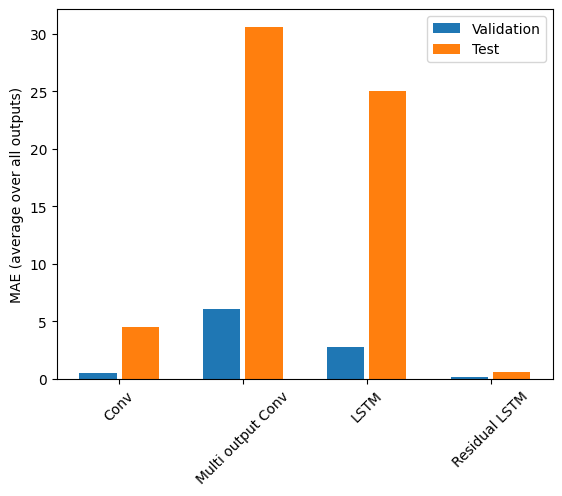

In [36]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [37]:
for name, value in performance.items():
  print(f'{name:15s}: {value[metric_name]:0.4f}')

Conv           : 4.5389
Multi output Conv: 30.6219
LSTM           : 25.0700
Residual LSTM  : 0.6200


Multi-step models

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

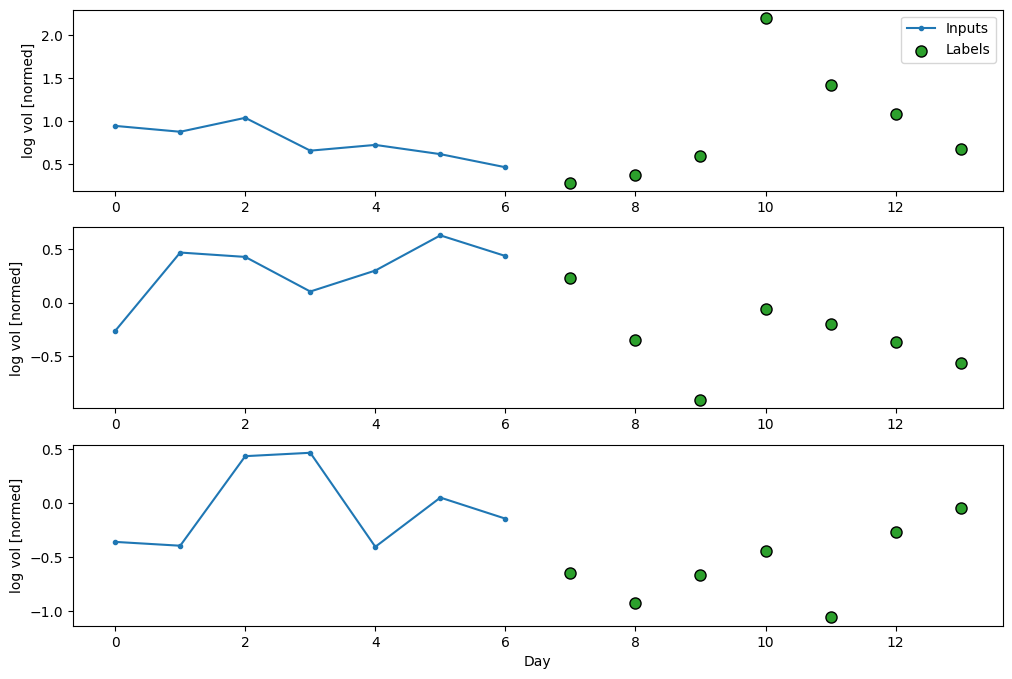

In [38]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

69/69 [==============================] - 0s 648us/step - loss: 1.3152 - mean_absolute_error: 0.6648


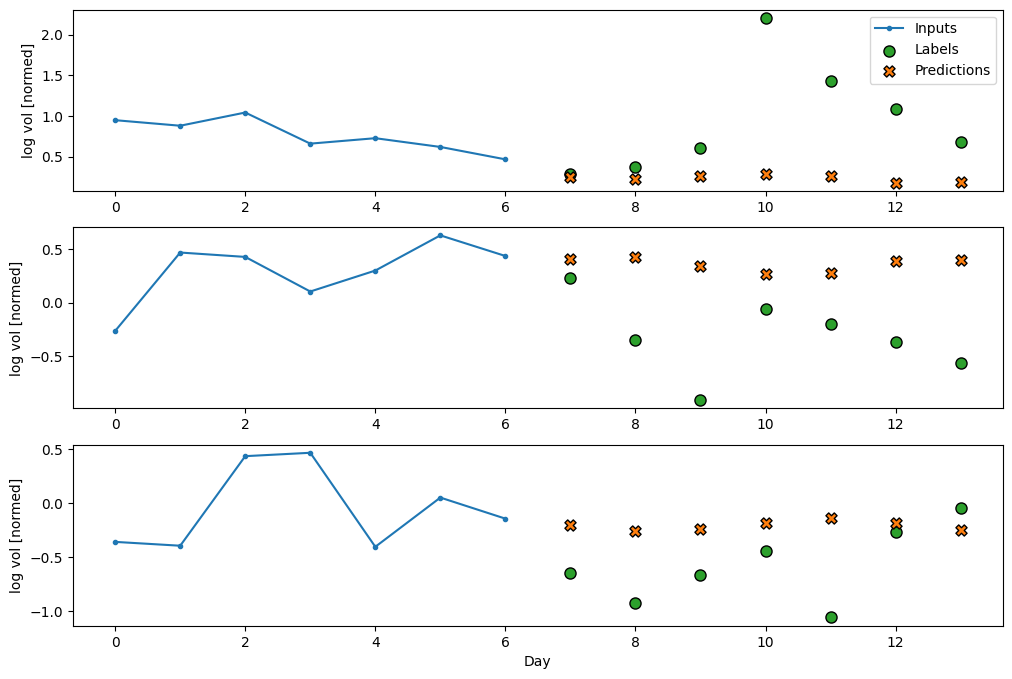

In [39]:
multi_val_performance = {}
multi_performance = {}
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

69/69 [==============================] - 0s 843us/step - loss: 0.5251 - mean_absolute_error: 0.4219


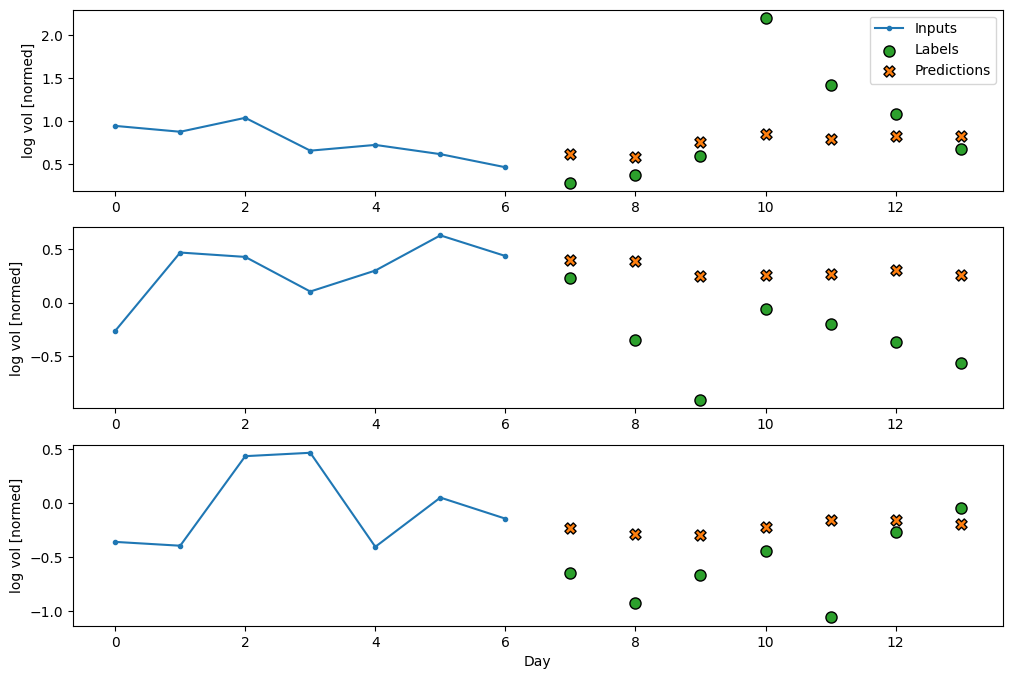

In [40]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

69/69 [==============================] - 0s 848us/step - loss: 0.5605 - mean_absolute_error: 0.4891


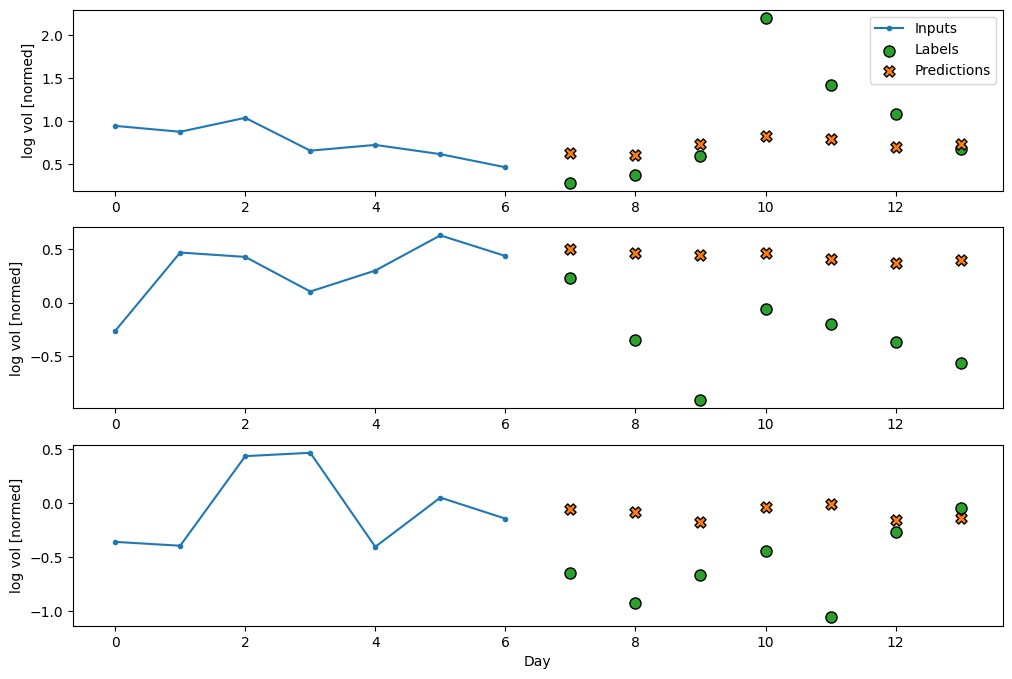

In [41]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

69/69 [==============================] - 0s 1ms/step - loss: 36.7963 - mean_absolute_error: 3.4481


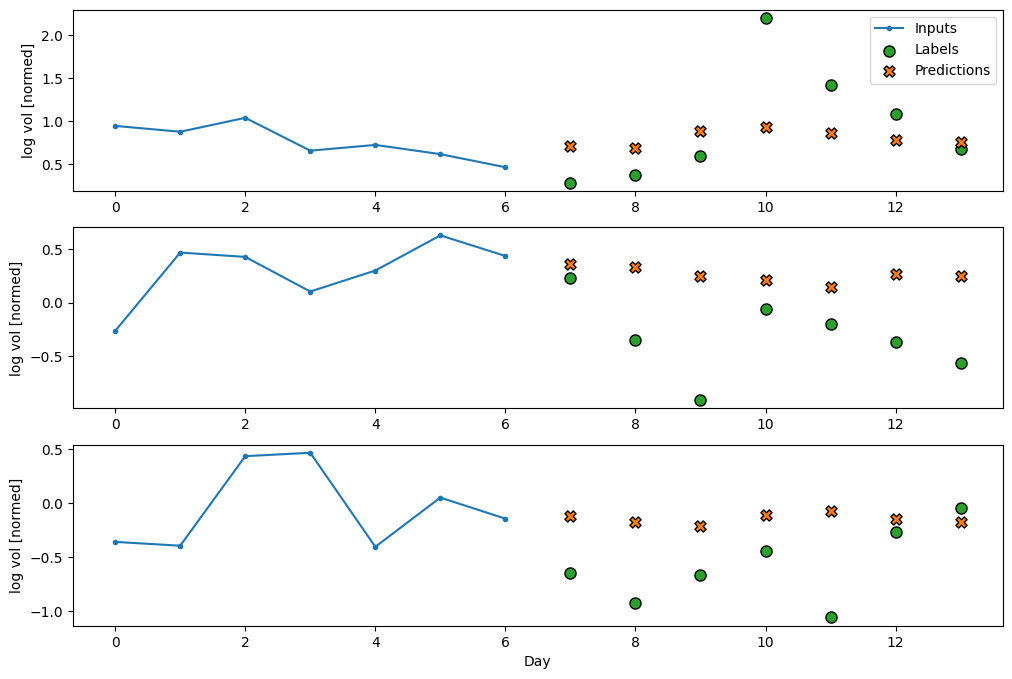

In [42]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

In [43]:
history = compile_and_fit(residual_lstm, multi_window)

IPython.display.clear_output()
multi_val_performance['Residual LSTM'] = residual_lstm.evaluate(multi_window.val, return_dict=True)
multi_performance['Residual LSTM'] = residual_lstm.evaluate(multi_window.test, verbose=0, return_dict=True)
print()

69/69 [==============================] - 0s 1ms/step - loss: 0.4072 - mean_absolute_error: 0.4319



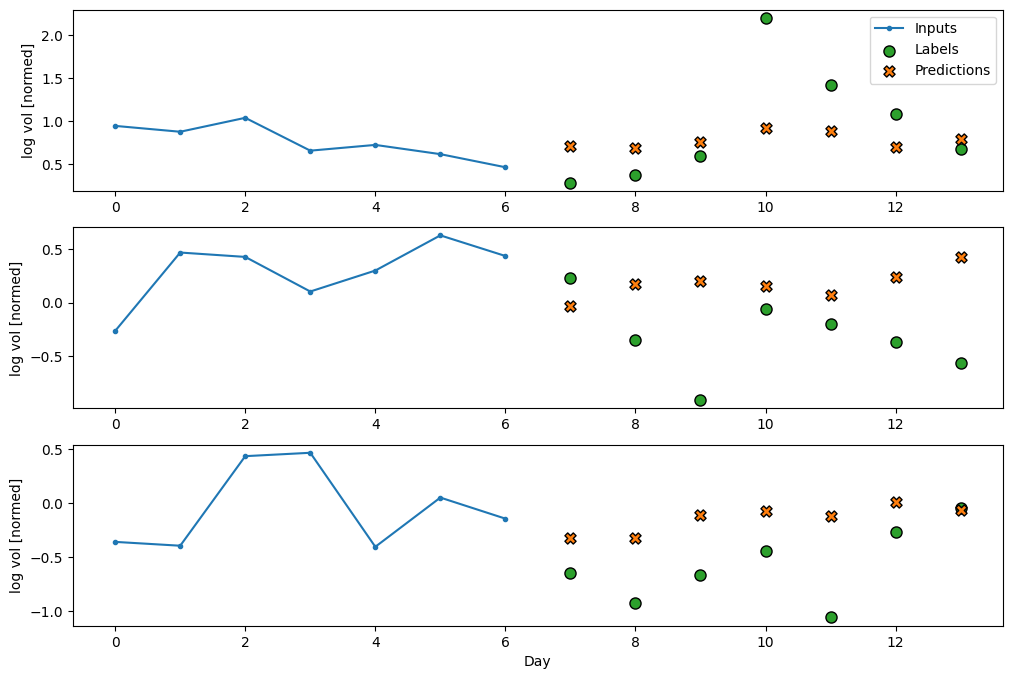

In [44]:
multi_window.plot(residual_lstm)

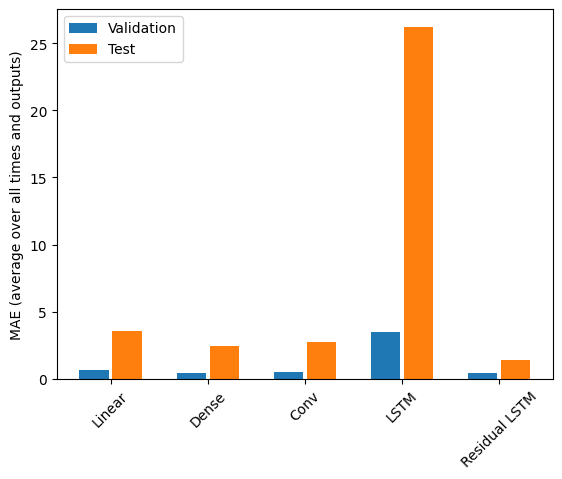

In [45]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

35/35 [==============================] - 0s 2ms/step


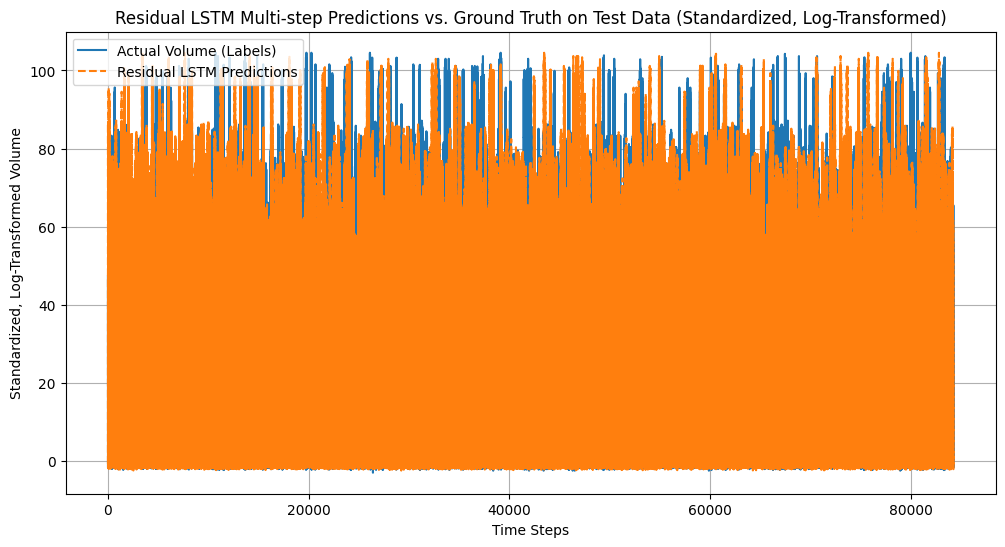

In [46]:
predictions = residual_lstm.predict(multi_window.test)

actual_volume = []
for inputs, labels in multi_window.test:
    actual_volume.extend(labels.numpy().flatten())

predictions_flat = predictions.flatten()
plt.figure(figsize=(12, 6))
plt.plot(actual_volume, label='Actual Volume (Labels)')
plt.plot(predictions_flat, label='Residual LSTM Predictions', linestyle='--')
plt.title('Residual LSTM Multi-step Predictions vs. Ground Truth on Test Data (Standardized, Log-Transformed)')
plt.xlabel('Time Steps')
plt.ylabel('Standardized, Log-Transformed Volume')  
plt.legend()
plt.grid(True)
plt.show()

## Modeling

### ARIMA

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(AAPL_data['Volume'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -5.402609038045689
p-value: 3.3447258277548513e-06


Since the p-value is > 0.5 the data is non-stationary and need differencing.

ARIMA requires a stationary series (constant mean and variance over time). Will use Augmented Dickey-Fuller to check for stationarity.

In [ ]:
# Apply differencing
AAPL_data['Volume_diff'] = AAPL_data['Volume'].diff().dropna()

/var/folders/ff/xvy4wjhn7hb6kbg62gnhtw2m0000gn/T/ipykernel_13276/1211233123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAPL_data['Volume_diff'] = AAPL_data['Volume'].diff().dropna()


In [ ]:
# Split data into train and test
train_data = AAPL_data[AAPL_data.index <= '2017-12-31']['Volume_diff']
test_data = AAPL_data[(AAPL_data.index > '2017-12-31') & (AAPL_data.index <= '2020-12-31')]['Volume_diff']

In [ ]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
# Define parameter ranges
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Generate all combinations of (p, d, q)
pdq_combinations = list(itertools.product(p, d, q))

# Track the best model
best_aic = float('inf')
best_order = None
best_model = None

# Grid search through all combinations
for order in pdq_combinations:
    try:
        model = ARIMA(train_data, order=order)
        fitted_model = model.fit()
        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_order = order
            best_model = fitted_model
    except Exception:
        continue

# Display the best parameters and AIC score
best_order, best_aic

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

((1, 0, 2), 384274.7445587093)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


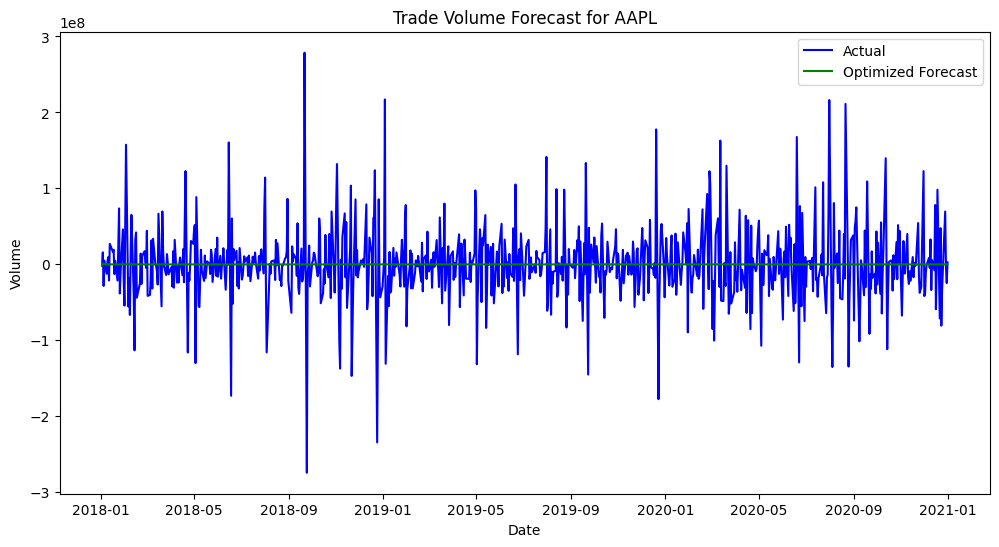

In [ ]:
optimized_model = ARIMA(train_data, order=best_order)
fitted_optimized_model = optimized_model.fit()
optimized_forecast = fitted_optimized_model.forecast(steps=len(test_data))

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual", color="blue")
plt.plot(test_data.index, optimized_forecast, label="Optimized Forecast", color="green")
plt.title('Trade Volume Forecast for AAPL')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
optimized_mae = mean_absolute_error(test_data, optimized_forecast)
optimized_rmse = np.sqrt(mean_squared_error(test_data, optimized_forecast))
optimized_mae, optimized_rmse

(33937664.177950546, 49907308.3709498)

### LSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0011 - val_loss: 7.1221e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 6.9135e-04 - val_loss: 6.8112e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.5527e-04 - val_loss: 6.6301e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 6.2699e-04 - val_loss: 6.3719e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 6.1041e-04 - val_loss: 6.7761e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.0569e-04 - val_loss: 6.3022e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 5.9650e-04 - val_loss: 6.7518e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.0343e-04 - val_loss: 7.1361e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.9069e-04 - val_loss: 6.3237e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 5.8779e-04 - val_loss: 6.4750e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0010 - val_loss: 9.0946e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 7.1148e-04 - val_loss: 8.8207e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6.8208e-04 - val_loss: 8.5632e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.6291e-04 - val_loss: 8.5677e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.4237e-04 - val_loss: 8.2698e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 6.4230e-04 - val_loss: 8.2512e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 6.4923e-04 - val_loss: 8.2178e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.3780e-04 - val_loss: 8.1595e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 6.3927e-04 - val_loss: 8.3740e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.2567e-04 - val_loss: 8.3244e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0012 - val_loss: 6.0864e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 8.2357e-04 - val_loss: 5.7907e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 7.6133e-04 - val_loss: 5.4350e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.2932e-04 - val_loss: 5.2920e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.2292e-04 - val_loss: 5.0987e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.1378e-04 - val_loss: 4.9743e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.9894e-04 - val_loss: 5.1467e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 7.0302e-04 - val_loss: 4.9659e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.0315e-04 - val_loss: 4.9382e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.8239e-04 - val_loss: 4.8811e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0011 - val_loss: 6.4250e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.3443e-04 - val_loss: 6.0254e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 7.9302e-04 - val_loss: 6.0468e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.4289e-04 - val_loss: 5.9534e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 7.2627e-04 - val_loss: 5.8798e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 7.1063e-04 - val_loss: 6.0721e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.0374e-04 - val_loss: 5.9747e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.0274e-04 - val_loss: 5.9736e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 6.8468e-04 - val_loss: 6.1552e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 7.0366e-04 - val_loss: 6.1359e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 9.9597e-04 - val_loss: 0.0012
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.4381e-04 - val_loss: 0.0012
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 7.1113e-04 - val_loss: 0.0011
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 6.7026e-04 - val_loss: 0.0011
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 6.5385e-04 - val_loss: 0.0010
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.3350e-04 - val_loss: 0.0010
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.3558e-04 - val_loss: 0.0010
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 6.3722e-04 - val_loss: 0.0010
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.4980e-04 - val_loss: 9.9924e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.3594e-04 - val_loss: 0.0010
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


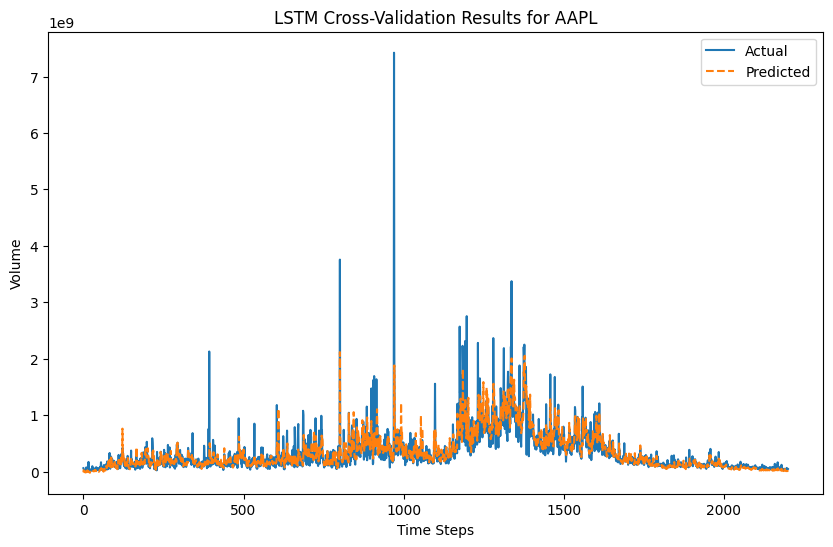

Cross-Validation Results for AAPL:
Fold MSE: [3.4713135192700268e+16, 4.4943070735319304e+16, 2.6885435623486572e+16, 3.2386470853370156e+16, 5.503913264274808e+16]
Average MSE: 38793449009524880.0000
Results for AAPL:
Average MSE: 38793449009524880.0000


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Cross-validation results storage
cv_results = {}

# Loop through each stock ticker in the dataset
# for ticker in dow_jones_df['Ticker'].unique():
ticker = 'AAPL'

stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]['Volume'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data_scaled = scaler.fit_transform(stock_data)

# Create sequences of 60 time steps
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(stock_data_scaled, time_steps)

# Reshape input for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Perform K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_mse = []
predictions_all_folds = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build the LSTM model with Dropout to prevent overfitting
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # EarlyStopping to avoid overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop])

    # Make predictions on the test fold
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate and store MSE for this fold
    mse = mean_squared_error(y_test_actual, predictions)
    fold_mse.append(mse)

    # Store predictions for visualization
    predictions_all_folds.append((y_test_actual, predictions))

# Store overall results for this stock
cv_results[ticker] = {
    'mse': fold_mse,
    'avg_mse': np.mean(fold_mse),
    'predictions': predictions_all_folds
}

# Plot actual vs predicted for the last fold
plt.figure(figsize=(10, 6))
plt.plot(predictions_all_folds[-1][0], label='Actual')
plt.plot(predictions_all_folds[-1][1], label='Predicted', linestyle='--')
plt.title(f'LSTM Cross-Validation Results for {ticker}')
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.show()

print(f"Cross-Validation Results for {ticker}:")
print(f"Fold MSE: {fold_mse}")
print(f"Average MSE: {np.mean(fold_mse):.4f}")

# Example: Access cross-validation results for a specific stock
ticker_example = list(cv_results.keys())[0]
print(f"Results for {ticker_example}:")
print(f"Average MSE: {cv_results[ticker_example]['avg_mse']:.4f}")


### Prophet

In [ ]:
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing

19:39:34 - cmdstanpy - INFO - Chain [1] start processing
19:39:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


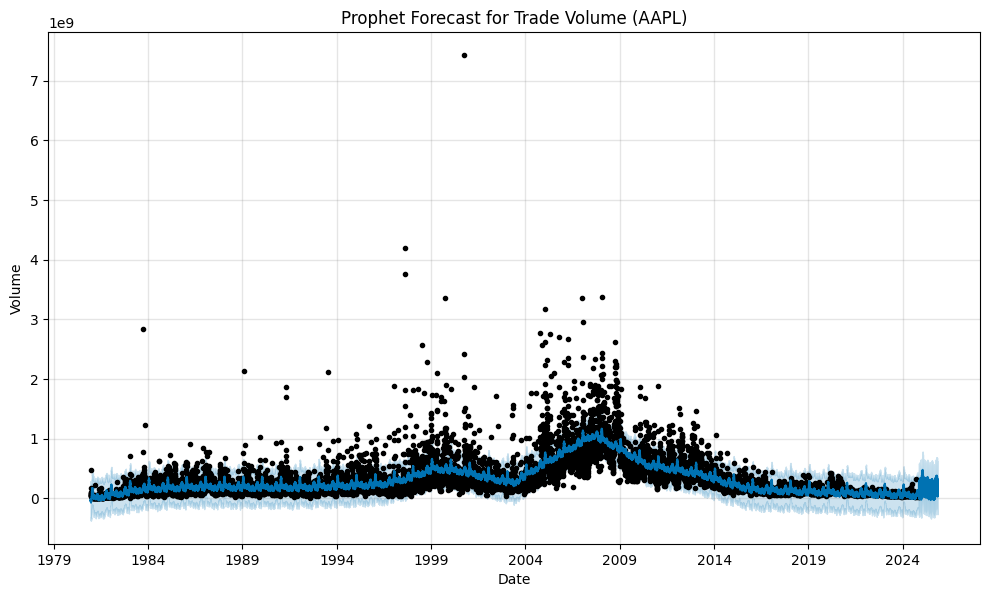

/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

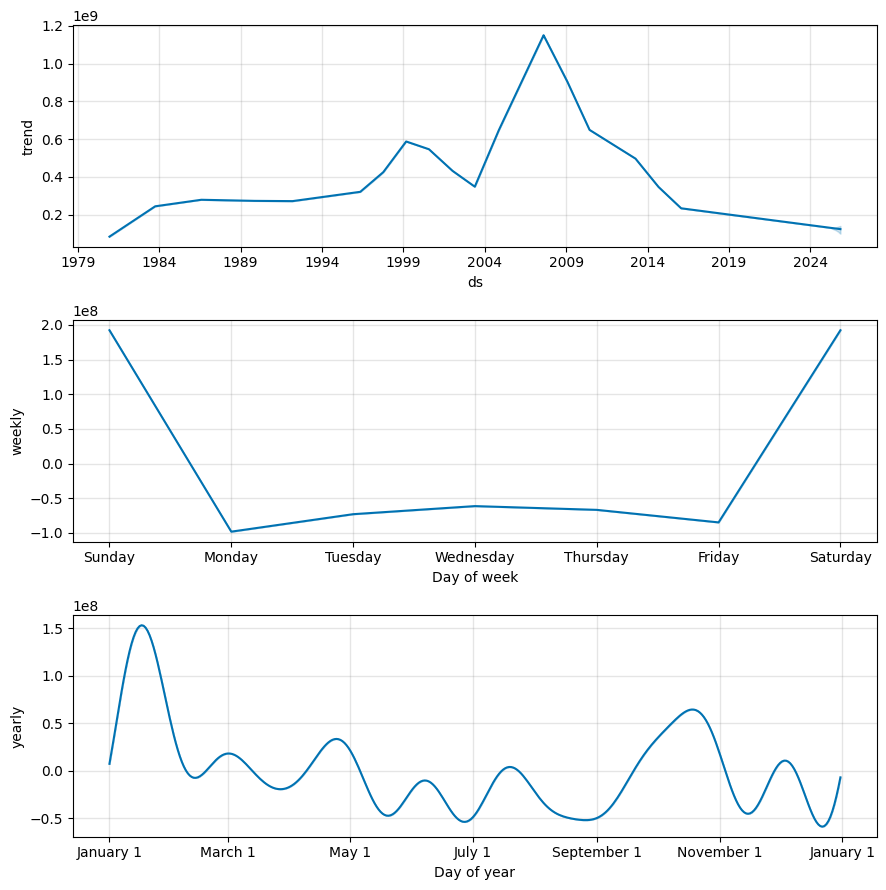

In [ ]:
# Filter data for the specified ticker
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]

# Prepare the data for Prophet
prophet_data = stock_data[['Volume']].reset_index()
prophet_data.columns = ['ds', 'y']  # Prophet requires columns 'ds' for dates and 'y' for values

# Remove timezone from 'ds' column
prophet_data['ds'] = prophet_data['ds'].dt.tz_localize(None)

# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Create a dataframe for future dates
future = model.make_future_dataframe(periods=365)  # Extend the forecast for 365 days
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Prophet Forecast for Trade Volume ({ticker})')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()


19:39:54 - cmdstanpy - INFO - Chain [1] start processing
19:40:03 - cmdstanpy - INFO - Chain [1] done processing


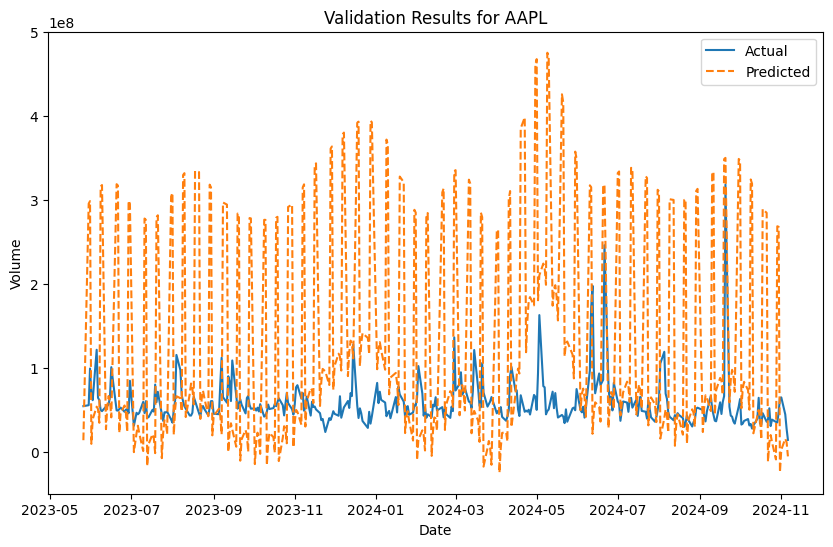

In [ ]:
# Split data into training and validation sets
train = prophet_data.iloc[:-365]
validation = prophet_data.iloc[-365:]

# Instantiate a new Prophet model
validation_model = Prophet()

# Fit the model on the training data
validation_model.fit(train)

# Make predictions for the validation set
validation_future = validation_model.make_future_dataframe(periods=len(validation))
validation_forecast = validation_model.predict(validation_future)

# Compare actual vs. predicted
validation_results = pd.DataFrame({
    'ds': validation['ds'],
    'Actual': validation['y'],
    'Predicted': validation_forecast['yhat'].iloc[-len(validation):].values
})

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(validation_results['ds'], validation_results['Actual'], label='Actual')
plt.plot(validation_results['ds'], validation_results['Predicted'], label='Predicted', linestyle='--')
plt.title(f'Validation Results for {ticker}')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


### Exponential Smoothing

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Squared Error: 7144222430775878.0000


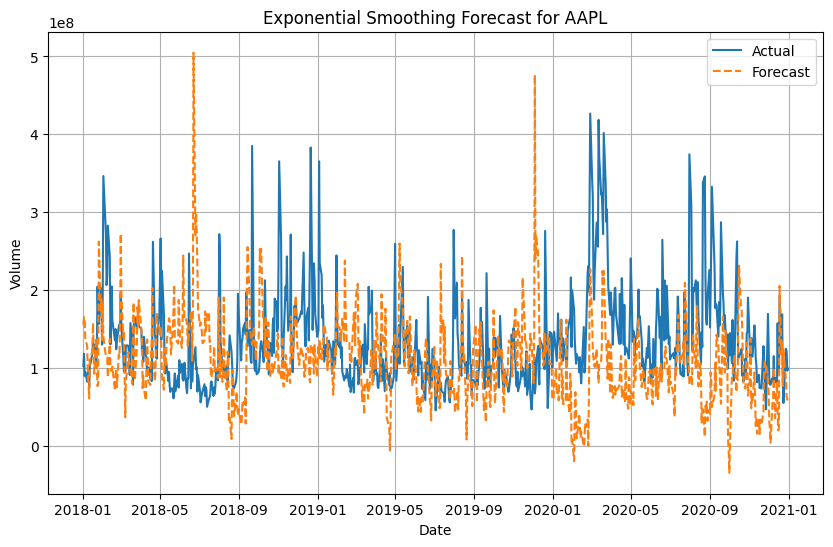

In [ ]:
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
volume_data = stock_data['Volume']

train = volume_data[volume_data.index <= '2017-12-31']
test = volume_data[(volume_data.index > '2017-12-31') & (volume_data.index <= '2020-12-31')]

# Fit the Exponential Smoothing model with trend and seasonality
model = ExponentialSmoothing(
    train,
    trend="additive",   # Additive trend
    seasonal="additive",  # Additive seasonality
    seasonal_periods=365,  # Define seasonal periods
)
fitted_model = model.fit(optimized=True)

# Forecast for the test period
forecast = fitted_model.forecast(steps=len(test))

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.4f}")

# Plot actual vs forecast
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title(f'Exponential Smoothing Forecast for {ticker}')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

### CatBoost

Training CatBoost model...
0:	learn: 343477784.9397839	test: 260135215.0998612	best: 260135215.0998612 (0)	total: 172ms	remaining: 57m 13s
50:	learn: 172460870.5151395	test: 88009937.1656231	best: 88009937.1656231 (50)	total: 3.96s	remaining: 25m 48s
100:	learn: 151756205.8765404	test: 71041554.9799508	best: 71041554.9799508 (100)	total: 5.26s	remaining: 17m 15s
150:	learn: 141019636.3507856	test: 65306230.8027939	best: 65306230.8027939 (150)	total: 6.59s	remaining: 14m 26s
200:	learn: 131547770.7518017	test: 64551658.1828656	best: 64477133.5940766 (196)	total: 7.9s	remaining: 12m 58s
250:	learn: 122726931.3295924	test: 63330919.6337843	best: 63330919.6337843 (250)	total: 9.24s	remaining: 12m 7s
300:	learn: 115829068.4449385	test: 62084144.8345858	best: 62084144.8345858 (300)	total: 10.5s	remaining: 11m 30s
350:	learn: 109284555.1709538	test: 61108126.0148482	best: 61056593.1610138 (345)	total: 11.9s	remaining: 11m 7s
400:	learn: 103882332.4011289	test: 59242295.4269898	best: 59235743.

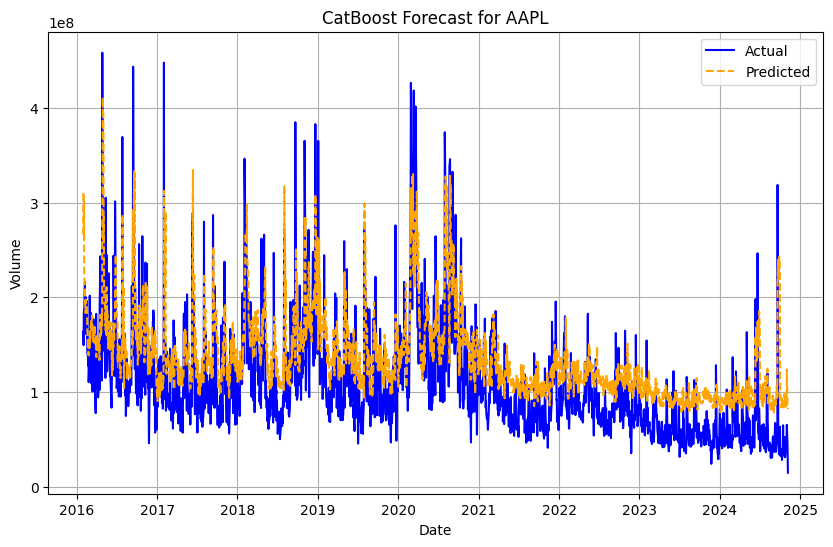

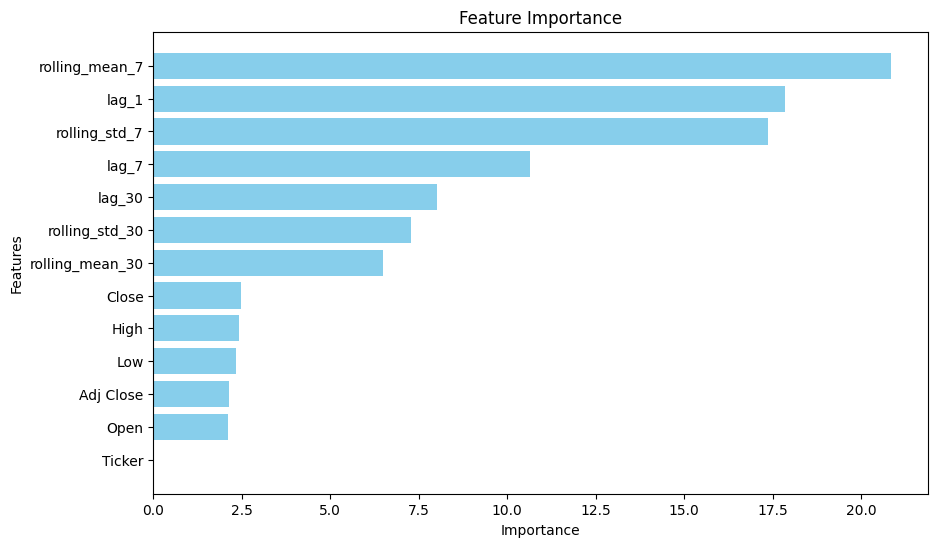

In [ ]:
from catboost import CatBoostRegressor

# Filter data for the specific ticker
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]

# Ensure the index is sorted
stock_data.sort_index(inplace=True)

# Add lag features and rolling statistics
def create_features(data, target_col, lags=[1, 7, 30], rolling_windows=[7, 30]):
    df = data.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df[target_col].rolling(window=window).std()
    df.dropna(inplace=True)
    return df

# Prepare the dataset
stock_data = create_features(stock_data, target_col='Volume')

# Train-test split (80-20)
train_size = int(len(stock_data) * 0.8)
train = stock_data.iloc[:train_size]
test = stock_data.iloc[train_size:]

# Define features and target
X_train = train.drop('Volume', axis=1)
y_train = train['Volume']
X_test = test.drop('Volume', axis=1)
y_test = test['Volume']

# Specify categorical features (e.g., Ticker)
cat_features = [X_train.columns.get_loc('Ticker')]  # Index of the 'Ticker' column

# Define CatBoost Regressor
catboost_model = CatBoostRegressor(
    iterations=20000,
    depth=10,
    learning_rate=0.05,
    loss_function='RMSE',
    eval_metric='RMSE',
    verbose=50,
    early_stopping_rounds=5000
)

# Train the model
print("Training CatBoost model...")
catboost_model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), use_best_model=True)

# Make predictions
print("Making predictions...")
predictions = catboost_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"CatBoost Mean Squared Error: {mse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predictions, label='Predicted', color='orange', linestyle='--')
plt.title(f'CatBoost Forecast for {ticker}')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': catboost_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()

Fold 1
0:	learn: 320877145.5537574	test: 336412081.8629766	best: 336412081.8629766 (0)	total: 61.9ms	remaining: 20m 38s
50:	learn: 153369438.7226939	test: 210429350.1086183	best: 210429350.1086183 (50)	total: 4.25s	remaining: 27m 43s
100:	learn: 134712174.6723436	test: 207580507.4545593	best: 207241369.8111618 (87)	total: 7.5s	remaining: 24m 37s
150:	learn: 123887315.0840160	test: 207515557.6143003	best: 207241369.8111618 (87)	total: 8.93s	remaining: 19m 34s
200:	learn: 115421089.6475833	test: 208315880.9890106	best: 207241369.8111618 (87)	total: 10.3s	remaining: 16m 52s
250:	learn: 106745621.3905286	test: 208550257.5696005	best: 207241369.8111618 (87)	total: 12.6s	remaining: 16m 34s
300:	learn: 99529260.7147409	test: 208876865.5171976	best: 207241369.8111618 (87)	total: 16.7s	remaining: 18m 13s
350:	learn: 94044031.5295853	test: 209344262.3243980	best: 207241369.8111618 (87)	total: 18.1s	remaining: 16m 52s
400:	learn: 88805319.0084039	test: 209473699.3401215	best: 207241369.8111618 (8

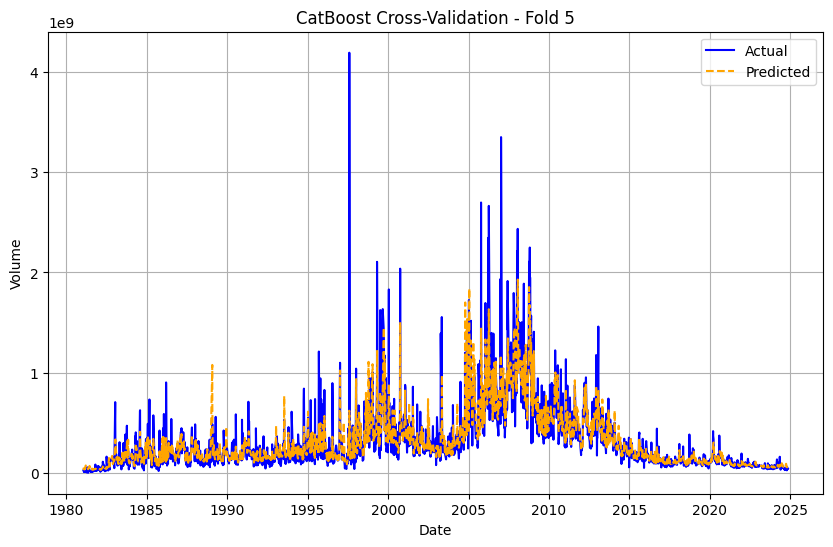

In [ ]:
# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for results
cv_mse = []
cv_predictions = []

# Filter data for the specific ticker
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]

# Ensure the index is sorted
stock_data.sort_index(inplace=True)

# Add lag features and rolling statistics
def create_features(data, target_col, lags=[1, 7, 30], rolling_windows=[7, 30]):
    df = data.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df[target_col].rolling(window=window).std()
    df.dropna(inplace=True)
    return df

# Prepare the dataset
stock_data = create_features(stock_data, target_col='Volume')

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(stock_data)):
    print(f"Fold {fold + 1}")

    # Split data into training and testing sets for this fold
    train, test = stock_data.iloc[train_index], stock_data.iloc[test_index]
    X_train, y_train = train.drop('Volume', axis=1), train['Volume']
    X_test, y_test = test.drop('Volume', axis=1), test['Volume']

    # Specify categorical features (e.g., Ticker)
    cat_features = [X_train.columns.get_loc('Ticker')]  # Index of the 'Ticker' column

    # Define CatBoost Regressor
    catboost_model = CatBoostRegressor(
        iterations=20000,
        depth=10,
        learning_rate=0.05,
        loss_function='RMSE',
        eval_metric='RMSE',
        verbose=50,
        early_stopping_rounds=5000
    )

    # Train the model
    catboost_model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), use_best_model=True)

    # Make predictions
    predictions = catboost_model.predict(X_test)

    # Calculate MSE for this fold
    mse = mean_squared_error(y_test, predictions)
    cv_mse.append(mse)

    # Store predictions for analysis
    cv_predictions.append((y_test, predictions))

    print(f"Fold {fold + 1} MSE: {mse:.4f}")

# Print Cross-Validation Results
print("\nCross-Validation Results:")
print(f"Mean MSE: {np.mean(cv_mse):.4f}")
print(f"Standard Deviation of MSE: {np.std(cv_mse):.4f}")

# Plot actual vs predicted for the last fold
actual, predicted = cv_predictions[-1]
plt.figure(figsize=(10, 6))
plt.plot(actual.index, actual, label='Actual', color='blue')
plt.plot(actual.index, predicted, label='Predicted', color='orange', linestyle='--')
plt.title(f'CatBoost Cross-Validation - Fold {len(cv_predictions)}')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

### DeepAR

In [14]:
import gluonts

In [26]:
from gluonts.dataset.common import ListDataset

# Filter data for a specific ticker
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker].sort_index()

# Prepare target and metadata
target = stock_data['Volume'].values
start_date = stock_data.index.min()

# Create the dataset
train_data = ListDataset(
    [{"start": start_date, "target": target[:-365]}],  # Exclude the last 365 days for testing
    freq="D"  # Daily frequency
)

test_data = ListDataset(
    [{"start": start_date, "target": target}],  # Use full data for evaluation
    freq="D"
)

[{'start': Period('1980-12-12', 'D'), 'target': array([4.690336e+08, 1.758848e+08, 1.057280e+08, ..., 5.074730e+07,
       4.514350e+07, 5.605830e+07], dtype=float32)}]
[{'start': Period('1980-12-12', 'D'), 'target': array([4.690336e+08, 1.758848e+08, 1.057280e+08, ..., 4.494450e+07,
       2.804440e+07, 1.466008e+07], dtype=float32)}]


In [18]:
import torch

# Set PyTorch to CPU
torch.set_default_device("cpu")

from gluonts.torch import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# Define DeepAR estimator
estimator = DeepAREstimator(
    freq="D",
    prediction_length=365,  # Reduced prediction length
    context_length=365,  # Reduced context length
    trainer_kwargs={
        "accelerator": "cpu",
        "max_epochs": 50,  # Limit epochs for debugging
    },
)

# Train the model
predictor = estimator.train(train_data)

# Evaluate
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data, predictor=predictor, num_samples=365
)
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(ts_it), iter(forecast_it))
print(agg_metrics)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:107: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes    
-----------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | ?        | [1, 100, 365]
-----------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 20.24365 (best 20.24365), saving model to 'C:\\Users\\Isaya Acevedo\\OneDrive - Northeastern University\\2024-2025\\Fall\\MATH 7339 ML Theory 2\\Final\\lightning_logs\\version_29\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 19.85781 (best 19.85781), saving model to 'C:\\Users\\Isaya Acevedo\\OneDrive - Northeastern University\\2024-2025\\Fall\\MATH 7339 ML Theory 2\\Final\\lightning_logs\\version_29\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 19.73870 (best 19.73870), saving model to 'C:\\Users\\Isaya Acevedo\\OneDrive - Northeastern University\\2024-2025\\Fall\\MATH 7339 ML Theory 2\\Final\\lightning_logs\\version_29\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 19.63449 (best 19.63449), saving model to 'C:\\Users\\Isaya Acevedo\\OneDrive - Northeastern University\\2024-2025\\Fall\\MATH 7339 ML Theo

{'MSE': 885207774440585.5, 'abs_error': 6451070976.0, 'abs_target_sum': 21178134528.0, 'abs_target_mean': 58022286.37808219, 'seasonal_error': 107480693.40310222, 'MASE': 0.16444038922644424, 'MAPE': 0.25017185995023544, 'sMAPE': 0.29812456940951415, 'MSIS': 1.946973473403961, 'QuantileLoss[0.1]': 2193097589.8, 'Coverage[0.1]': 0.00821917808219178, 'QuantileLoss[0.2]': 3737944116.7999997, 'Coverage[0.2]': 0.024657534246575342, 'QuantileLoss[0.3]': 4949031809.2, 'Coverage[0.3]': 0.06575342465753424, 'QuantileLoss[0.4]': 5839216227.2, 'Coverage[0.4]': 0.1095890410958904, 'QuantileLoss[0.5]': 6451070964.0, 'Coverage[0.5]': 0.2, 'QuantileLoss[0.6]': 6787599032.0, 'Coverage[0.6]': 0.3232876712328767, 'QuantileLoss[0.7]': 6842807485.599999, 'Coverage[0.7]': 0.4712328767123288, 'QuantileLoss[0.8]': 6511013022.4, 'Coverage[0.8]': 0.5945205479452055, 'QuantileLoss[0.9]': 5243179195.2, 'Coverage[0.9]': 0.7534246575342466, 'RMSE': 29752441.487054225, 'NRMSE': 0.5127760959501443, 'ND': 0.304609972

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Stock data shape: (11068, 7)
Stock data index: DatetimeIndex(['1980-12-12 00:00:00+00:00', '1980-12-15 00:00:00+00:00',
               '1980-12-16 00:00:00+00:00', '1980-12-17 00:00:00+00:00',
               '1980-12-18 00:00:00+00:00', '1980-12-19 00:00:00+00:00',
               '1980-12-22 00:00:00+00:00', '1980-12-23 00:00:00+00:00',
               '1980-12-24 00:00:00+00:00', '1980-12-26 00:00:00+00:00',
               ...
               '2024-10-24 00:00:00+00:00', '2024-10-25 00:00:00+00:00',
               '2024-10-28 00:00:00+00:00', '2024-10-29 00:00:00+00:00',
               '2024-10-30 00:00:00+00:00', '2024-10-31 00:00:00+00:00',
               '2024-11-01 00:00:00+00:00', '2024-11-04 00:00:00+00:00',
               '2024-11-05 00:00:00+00:00', '2024-11-06 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=11068, freq=None)


C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:107: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes    
-----------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | ?        | [1, 100, 365]
-----------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 20.25045 (best 20.25045), saving model to 'C:\\Users\\Isaya Acevedo\\OneDrive - Northeastern University\\2024-2025\\Fall\\MATH 7339 ML Theory 2\\Final\\lightning_logs\\version_30\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 19.88445 (best 19.88445), saving model to 'C:\\Users\\Isaya Acevedo\\OneDrive - Northeastern University\\2024-2025\\Fall\\MATH 7339 ML Theory 2\\Final\\lightning_logs\\version_30\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 19.77866 (best 19.77866), saving model to 'C:\\Users\\Isaya Acevedo\\OneDrive - Northeastern University\\2024-2025\\Fall\\MATH 7339 ML Theory 2\\Final\\lightning_logs\\version_30\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 19.66360 (best 19.66360), saving model to 'C:\\Users\\Isaya Acevedo\\OneDrive - Northeastern University\\2024-2025\\Fall\\MATH 7339 ML Theo

Number of forecasts: 1
Number of time series: 1


<Figure size 1000x600 with 0 Axes>

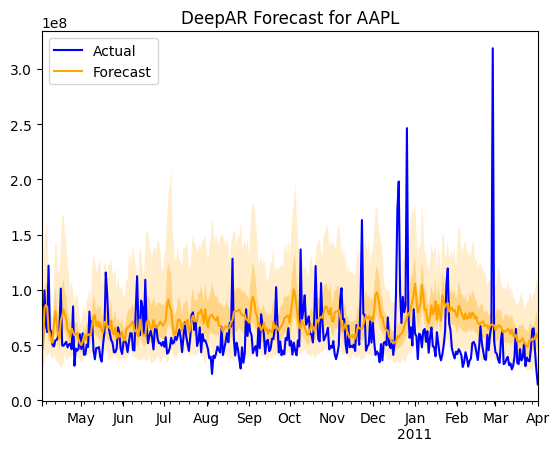

In [32]:
from gluonts.dataset.common import ListDataset
import torch
import matplotlib.pyplot as plt

# Filter data for a specific ticker
ticker = 'AAPL'
stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker].sort_index()

print("Stock data shape:", stock_data.shape)
print("Stock data index:", stock_data.index)

# Prepare target and metadata
target = stock_data['Volume'].values
start_date = stock_data.index.min()

# Create the dataset
train_data = ListDataset(
    [{"start": start_date, "target": target[:-365]}],  # Exclude the last 365 days for testing
    freq="D"  # Daily frequency
)
test_data = ListDataset(
    [{"start": start_date, "target": target}],  # Use full data for evaluation
    freq="D"
)

# Set PyTorch to CPU
torch.set_default_device("cpu")
from gluonts.torch import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

estimator = DeepAREstimator(
    freq="D",
    prediction_length=365, 
    context_length=365,
    trainer_kwargs={
        "accelerator": "cpu",
        "max_epochs": 50, 
        "enable_progress_bar": True, 
    },
)

try:
    predictor = estimator.train(train_data)
except Exception as e:
    print("Error during model training:", e)
    raise

try:
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data, predictor=predictor, num_samples=365
    )
    
    # Convert to lists
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    print("Number of forecasts:", len(forecasts))
    print("Number of time series:", len(tss))
    
    if not forecasts:
        print("No forecasts generated")
    else:
        # Extract the time range for the forecast
        forecast_start = forecasts[0].start_date
        forecast_end = forecasts[0].start_date + len(forecasts[0].mean) * pd.Timedelta(days=1)
        
        # Slice the actual time series to match the forecast range
        actual_during_forecast = tss[0][forecast_start:forecast_end]
        
        # Plot the overlapping part of the actual time series and forecast
        plt.figure(figsize=(10, 6))
        actual_during_forecast.plot(label="Actual", color="blue")
        forecasts[0].plot(color="orange")  # Plot forecast with confidence intervals
        
        plt.title(f"DeepAR Forecast for {ticker}")
        plt.legend(["Actual", "Forecast"])
        plt.show()

except Exception as e:
    print("Error during forecast generation:", e)
    raise